In [145]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
import pandas as pd
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing


from datetime import datetime

from bokeh.models import TabPanel, Tabs
from bokeh.plotting import show, output_notebook

# Geospatial Visuals using ACLED Package

In [146]:
data = pd.read_csv('../data/raw_acled_syria_20260122.csv')
processing.data_type_conversion(data)

In [147]:
def get_conflict_category(date):
    if date < pd.Timestamp('2024-11-27') and date >= pd.Timestamp('2023-11-26'):
        return 'Before Regime Change'
    elif date > pd.Timestamp('2024-12-08') and date <= pd.Timestamp('2025-12-09'):
        return 'After Regime Change'

In [148]:
category_list = ['Before Regime Change', 'After Regime Change']

In [149]:
data.loc[:,'category'] =data['event_date'].apply(get_conflict_category)

In [150]:
conflict_daily = processing.get_acled_by_group(
    data, columns=["latitude", "longitude", "category"], freq="D"
)

In [151]:
daily_mean = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities']].mean().reset_index()

In [152]:
daily_mean = processing.convert_to_gdf(daily_mean)

In [153]:
import geopandas as gpd
adm0 = gpd.read_file('../data/boundaries/syria/syr_admin0.shp')
syria_adm1 = gpd.read_file('../data/boundaries/syria/syr_admin1.shp')

## No spatial aggregation 

### Mean Conflict Events and Fatalities

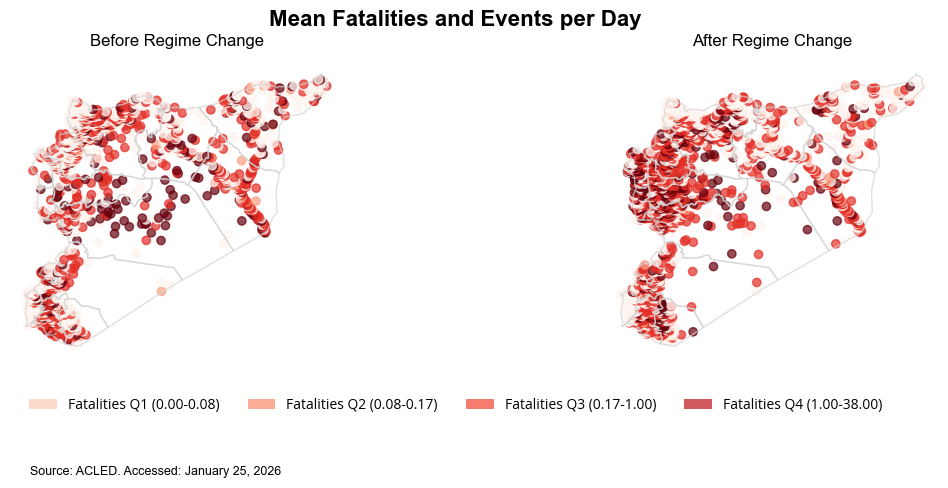

In [154]:
fig, ax = visuals.create_comparative_maps(daily_mean, 
                                title='Mean Fatalities and Events per Day',
                                measures={'nrFatalities':{'label_name':'Fatalities'}},
                                aggregation='latlon',
                                categories=category_list,
                                boundary_gdf=syria_adm1,
                                figsize=(15,5)
                                )

### Mean Conflict Index

The conflict intensity index is calculated as the geometric mean of conflict events and fatalities, with an adjustment to handle zero values:

$$\text{Conflict Intensity Index} = \sqrt{(\text{nrEvents}) \times (\text{nrFatalities} + 1)}$$

Where:
- $\text{nrEvents}$ is the number of conflict events in a given period and location
- $\text{nrFatalities}$ is the number of fatalities from conflicts in the same period and location
- The addition of 1 to each term ensures the index is defined even when either component is zero. This is arbitrary and is doen just to account for 0 values of fatalities and conflicts. 

This index provides a balanced measure that accounts for both the frequency of conflicts and their severity.  Compared to arithmetic means, the geometric mean reduces the influence of extreme values in either component (conflict events + fatalities). Areas with both high events and high fatalities will have higher index values than areas with many events but few fatalities or vice versa.

Conflict index is calculated at the location and then average is taken over time (across the three time periods). This is to preserve the integrity of the conflict index in that specific location. 

In [155]:
import numpy as np
conflict_daily['conflict_intensity_index_op1'] = np.sqrt((conflict_daily['nrEvents']) * 
                                           (conflict_daily['nrFatalities'] + 1))

In [156]:
daily_conflict_intensity = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()
daily_conflict_intensity = processing.convert_to_gdf(daily_conflict_intensity)

## Hexagonal Aggregation
Below are maps where the fatalities and conflict events are aggregated to hexagons of size 276 sq km each. This shows greater variance spatially.

In [157]:
h3_boundary = processing.convert_to_h3_grid(adm0, resolution=5)

In [158]:
conflict_daily_h3 = processing.get_acled_by_admin(h3_boundary, data, columns=['h3_index', 'category'], freq='D')
conflict_daily_h3.drop(columns=['index'], inplace=True)

In [159]:
conflict_daily_h3['conflict_intensity_index_op1'] = np.sqrt((conflict_daily_h3['nrEvents']) * 
                                           (conflict_daily_h3['nrFatalities'] + 1))

In [160]:
conflict_daily_h3_mean = conflict_daily_h3.groupby(['h3_index', 'category'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()

In [161]:
conflict_daily_h3_mean = h3_boundary.merge(conflict_daily_h3_mean, on='h3_index', how='left')

In [162]:
# Format extraction date in readable format
extraction_date = datetime.now().strftime('%B %d, %Y')
extraction_date

'January 25, 2026'

### Mean Conflict Index

The average conflict index measure shows the difference in the three periods very effectively compared to a showing mean conflict events and fatalities separately on the same map. 

### Mean Conflict Events

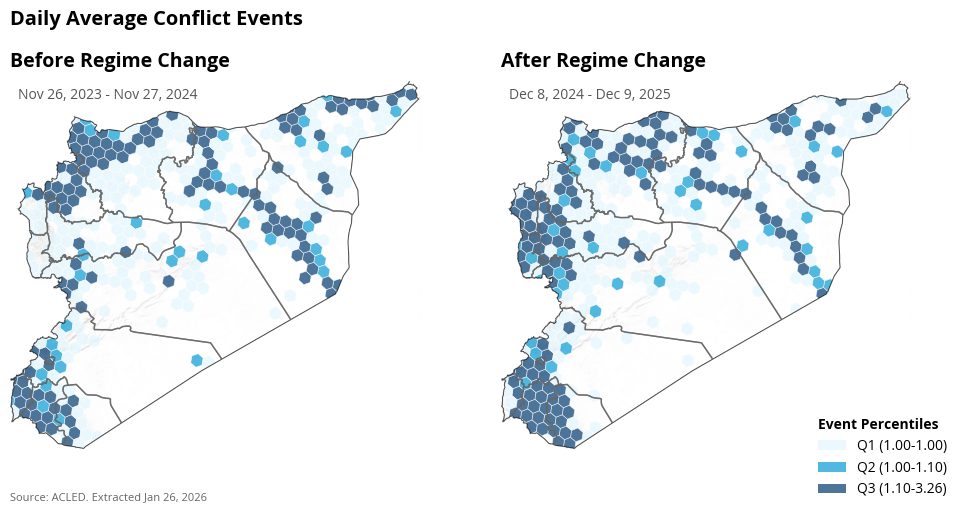

In [ ]:
fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    'Daily Average Conflict Events', 
    measure='nrEvents',
    category_list=category_list,
    custom_colors=["#E3F6FD",
"#089BD4",
"#023B6F"],
    country_boundary=adm0,
    admin1_boundary=syria_adm1,
    basemap_choice='',
    basemap_alpha=0.5,
        date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Event Percentiles'
)

### Mean Fatalities

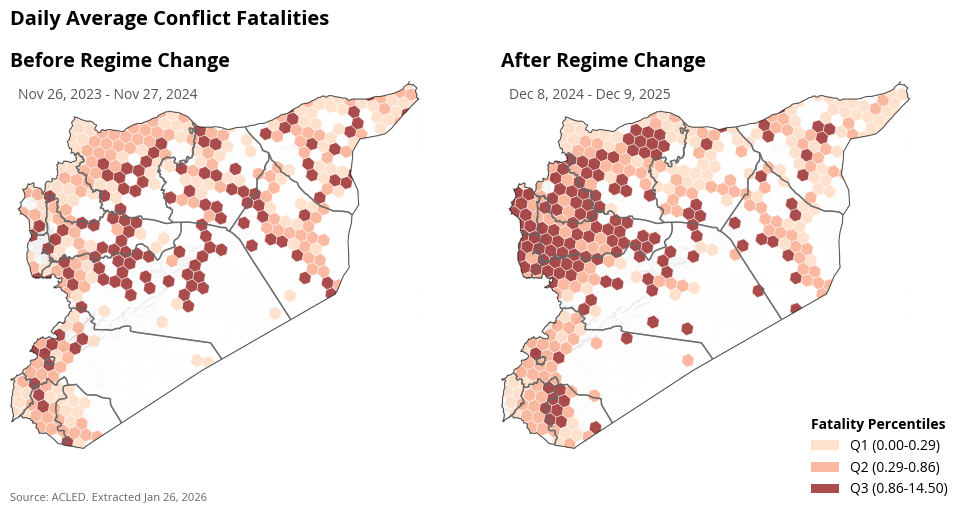

In [ ]:
fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    'Daily Average Conflict Fatalities', 
    measure='nrFatalities',
    category_list=category_list,
    custom_colors=['#ffd6b9', '#f99c78',  '#870000'],
    country_boundary=adm0,
    admin1_boundary=syria_adm1,
    basemap_choice='',
    basemap_alpha=0.5,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Fatality Percentiles'
)

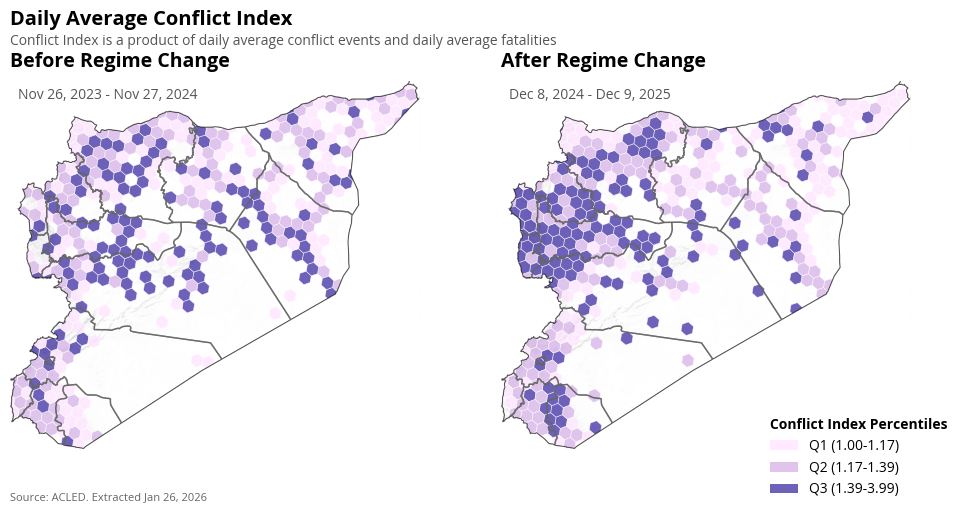

In [ ]:
fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean, 
    title = 'Daily Average Conflict Index', 
    subtitle='Conflict Index is a product of daily average conflict events and daily average fatalities',
    measure='conflict_intensity_index_op1',
    category_list=category_list,
    custom_colors=['#FFE2FF',
'#D3ACE6',
'#2F1E9C'],
    country_boundary=adm0,
    admin1_boundary=syria_adm1,
    basemap_choice='',
    basemap_alpha=0.5,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    },
    legend_title='Conflict Index Percentiles'
)

## Bivariate Conflict Map

This last option does not use any formula on conflict events or fatalities, it simply uses one single color to show the combination of these two. 

Conflict events and fatalities are divided into low-medium and high (equal quantiles of the data) and color is given accordingly. 

### Combination of mean conflict events and fatalities

/Users/ssarva/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  func(*args, **kwargs)
/Users/ssarva/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  fig.canvas.print_figure(bytes_io, **kw)


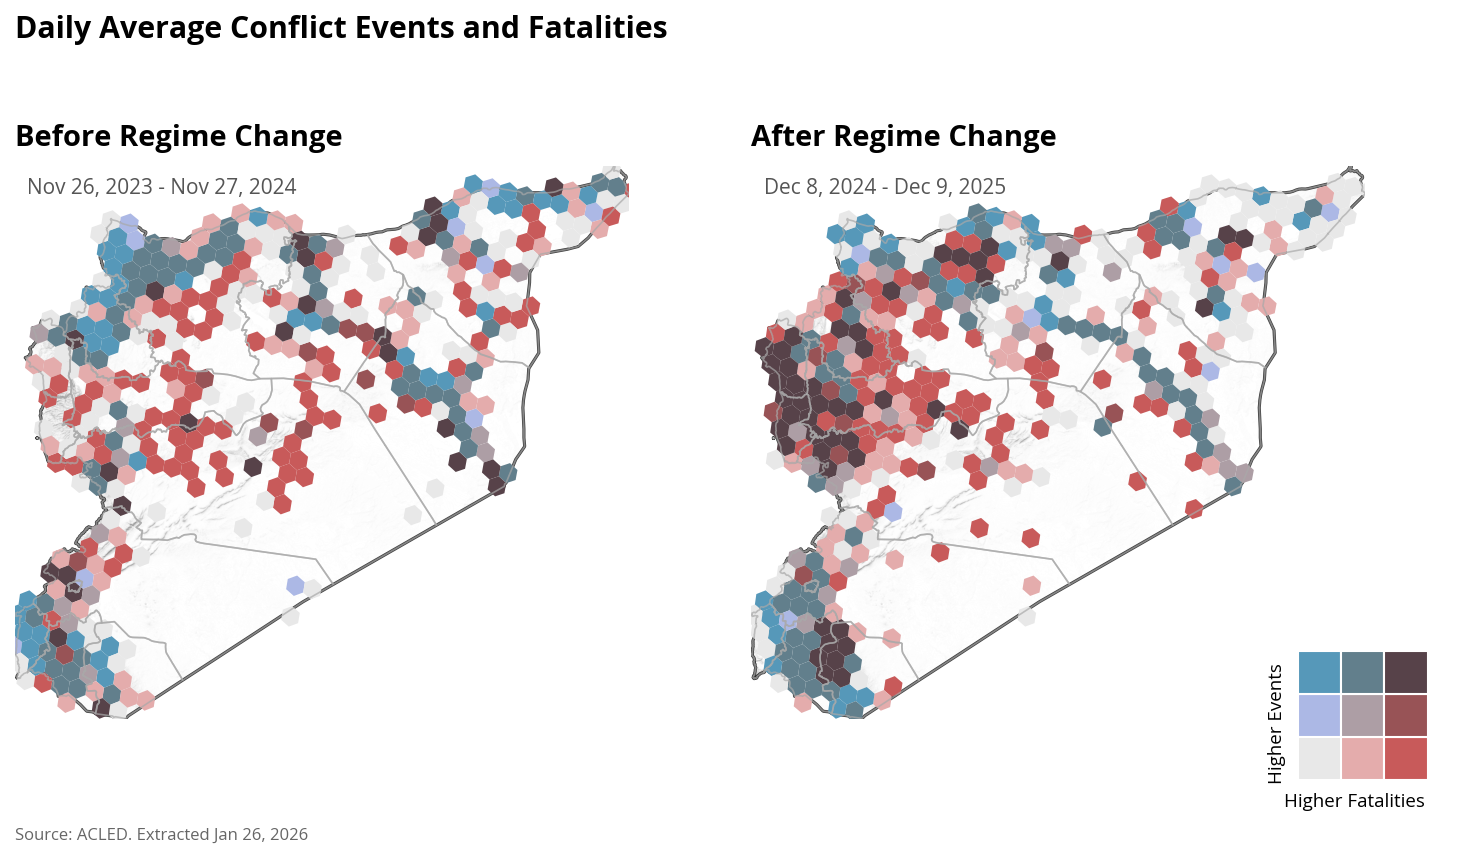

In [ ]:
fig, ax = visuals.create_bivariate_map_with_basemap(
    conflict_data=conflict_daily_h3_mean,
    category_list=category_list,
    country_boundary=adm0,
    admin1_boundary=syria_adm1,
    main_title="Daily Average Conflict Events and Fatalities",
    basemap_choice='',
    basemap_alpha=1,
    hexagon_alpha=1,
    date_ranges={
        'Before Regime Change': 'Nov 26, 2023 - Nov 27, 2024',
        'After Regime Change': 'Dec 8, 2024 - Dec 9, 2025'
    }
)